<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Package Imports
</p>

In [1]:
# General imports:-

# Data processing:-
import numpy as np
import pandas as pd
import re
from scipy.stats import mode, iqr, anderson, shapiro, normaltest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
pd.options.display.max_rows = 50
pd.set_option('display.float_format', '{:,.5f}'.format)

# Visualization:-
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Others:-
from warnings import filterwarnings; filterwarnings('ignore')
from tqdm.notebook import tqdm
from termcolor import colored
from gc import collect
from IPython.display import clear_output, HTML, display

In [4]:
# Model imports:-

from sklearn import datasets
from sklearn.metrics import mean_squared_error,make_scorer, r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, PowerTransformer, RobustScaler

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 22px; text-align: left; padding: 10px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Project description
</p>

<div style="color: #333333; 
           display: block; 
           border-radius: 12px;
           background-color: #FAFBFD; 
           font-size: 14px; 
           font-family: 'Roboto', sans-serif; 
           letter-spacing: 0.5px;
           padding: 20px; 
           border: 1px solid #CCCCCC; 
           ">

The data is generated by a deep learning model trained on the California housing dataset. The relationships between variables are similar to the original dataset, but not exactly the same.

We are working with three distinct datasets: the Training dataset, which includes both the predictor variables and the dependent variable; the Testing dataset, which contains only the predictor variables; and the original dataset obtained from Scikit-learn, the source for both the training and testing datasets.  
    

The Predicted variable is the **Median house value** for California districts, expressed in hundreds of thousands of dollars ($100,000). The independent variables at our disposal are:

* **Median Income (MedInc)**: Reflects the median income within each block group.
* **Median House Age (HouseAge)**: Provides a glimpse into the age distribution of housing, hinting at the area's development history.
* **Average Rooms (AveRooms)**: The average number of rooms per household.
* **Average Bedrooms (AveBedrms)**: Reveals the average number of bedrooms per household.
* **Population**: The total number of individuals residing within a block group, offering a sense of community size.
* **Average Household Members (AveOccup)**: The average number of people living in each household, reflecting on family or living unit sizes.
* **Latitude & Longitude**: Geographic coordinates that pinpoint the precise location of each block group, which will not be utilized in this analysis.

Our lens for evaluating the model's performance is the R^2 metric.


In the initial segment of our analysis, we will undertake a comprehensive examination of the dataset. This includes the identification and treatment of missing values, an assessment of feature distribution, the detection of outliers, and the conduct of normality tests. These steps are critical for ensuring the quality and reliability of our data prior to any further analysis.

The second phase will focus on correcting anomalies that were identified early on. This stage is crucial for improving the dataset's overall integrity, thus establishing a robust foundation for subsequent predictive modeling endeavors.

The final segment of our study is dedicated to the development and implementation of a Ridge Regression model.  
</div>

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Assigning global variables
</p>

In [5]:
# Assigning global variables to be used throughout:- 
target = 'MedHouseVal'

grid_specs = {'visible': True, 'which': 'both', 'linestyle': '--', 
              'color': 'lightgrey', 'linewidth': 0.50}
title_specs = {'fontsize': 14, 'fontweight': 'bold', 'color': 'tab:blue'}

def PrintColor(text:str, color:str = 'blue', attrs:list = ['bold', 'dark']):
    """
    Prints color outputs using termcolor-colored using a text F-string
    """
    print(colored(text, color = color, attrs = attrs))

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Importing Train and Test Dataset
</p>

In [8]:
%%time

# Importing the data:-
xytrain = pd.read_csv('../data/train.csv', encoding = 'utf8', index_col= 'id')
xtest = pd.read_csv('../data/test.csv', encoding = 'utf8', index_col= 'id')

# Displaying the datasets:-
PrintColor(f"\nTrain data\n")
display(xytrain.head(5))

PrintColor(f"\nTest data\n")
display(xtest.head(5))

PrintColor(f"\nAlternative House Price dataset - Scikit-learn\n")
alt_xytrain= datasets.fetch_california_housing(as_frame=True, return_X_y=False)['frame']
display(alt_xytrain.head(5))

PrintColor(f"\nExtracting features from Test data\n")
features = xtest.columns
display(features)

PrintColor(f"\nConverting the Target into 100k value\n")
xytrain[target] = xytrain[target] * 100_000
alt_xytrain[target] = alt_xytrain[target] * 100_000

PrintColor(f"\nTrain data\n")
display(xytrain.head(5))

print();

FileNotFoundError: [Errno 2] No such file or directory: '../data/train.csv'

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Preprocessing and Data augmentation
</p>

In [93]:
PrintColor("\nExtracting attribute information from Scikit-learn dataset\n");
print(datasets.fetch_california_housing()['DESCR']);


Extracting attribute information from Scikit-learn dataset

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds 

In [94]:
PrintColor(f"\nExtracting unique records per feature from Train, Test and Scikit-learn data\n");

PrintColor(f"\nTrain data unique records\n");
display(xytrain.nunique());

PrintColor(f"\nTest data unique records\n");
display(xtest.nunique());

PrintColor(f"\nSklearn data unique records\n");
display(alt_xytrain.nunique());


Extracting unique records per feature from Train, Test and Scikit-learn data


Train data unique records



MedInc         12310
HouseAge          51
AveRooms       22069
AveBedrms      14066
Population      3694
AveOccup       21078
Latitude         791
Longitude        755
MedHouseVal     3723
dtype: int64


Test data unique records



MedInc        10239
HouseAge         51
AveRooms      16763
AveBedrms     11147
Population     3454
AveOccup      15938
Latitude        745
Longitude       736
dtype: int64


Sklearn data unique records



MedInc         12928
HouseAge          52
AveRooms       19392
AveBedrms      14233
Population      3888
AveOccup       18841
Latitude         862
Longitude        844
MedHouseVal     3842
dtype: int64

In [95]:
PrintColor(f"\nData information - Train, Test and Scikit-learn data", color = 'black');

PrintColor(f"\nTrain data information\n");
display(xytrain.info());

PrintColor(f"\nTest data information\n");
display(xtest.info());

PrintColor(f"\nScikit-learn data information\n");
display(alt_xytrain.info());


Data information - Train, Test and Scikit-learn data

Train data information

<class 'pandas.core.frame.DataFrame'>
Index: 37137 entries, 0 to 37136
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       37137 non-null  float64
 1   HouseAge     37137 non-null  float64
 2   AveRooms     37137 non-null  float64
 3   AveBedrms    37137 non-null  float64
 4   Population   37137 non-null  float64
 5   AveOccup     37137 non-null  float64
 6   Latitude     37137 non-null  float64
 7   Longitude    37137 non-null  float64
 8   MedHouseVal  37137 non-null  float64
dtypes: float64(9)
memory usage: 2.8 MB


None


Test data information

<class 'pandas.core.frame.DataFrame'>
Index: 24759 entries, 37137 to 61895
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      24759 non-null  float64
 1   HouseAge    24759 non-null  float64
 2   AveRooms    24759 non-null  float64
 3   AveBedrms   24759 non-null  float64
 4   Population  24759 non-null  float64
 5   AveOccup    24759 non-null  float64
 6   Latitude    24759 non-null  float64
 7   Longitude   24759 non-null  float64
dtypes: float64(8)
memory usage: 1.7 MB


None


Scikit-learn data information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


None

<div style="color: #333333; 
           display: block; 
           border-radius: 12px;
           background-color: #FAFBFD; 
           font-size: 14px; 
           font-family: 'Roboto', sans-serif; 
           letter-spacing: 0.5px;
           padding: 20px; 
           border: 1px solid #CCCCCC; 
           ">
    None of the three datasets contain null values.
</div>

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Creating a function to offer a comprehensive summary of the Training, Testing, and Scikit-learn datasets.
</p>

In [96]:
def describe_dataframes(*dataframes, percentiles, target, sources):
    """
    Generate and display descriptive statistics for given dataframes.

    Parameters:
    - dataframes: Tuples of DataFrame and its corresponding source name.
    - percentiles: List of percentiles to calculate.
    - target: The target variable to exclude from the description.
    - sources: List of source names for each dataframe.
    """
    # Initialize an empty list to hold the modified dataframes
    described_dfs = []
    
    for df, source in zip(dataframes, sources):
        # Calculate descriptive statistics, excluding 'count', for each dataframe
        described = df.drop(target, axis=1, errors = 'ignore')\
        .describe(percentiles = percentiles).transpose().drop(['count'], axis=1)
        described.insert(0, 'source', source)
        described.reset_index(inplace = True)
        described.set_index(['index','source'], inplace=True)
        described_dfs.append(described)
      
    # Concatenate and display the results
    all_described = pd.concat(described_dfs, axis=0).sort_index(ascending=[True,False])
    display(all_described.style.format(formatter='{:.2f}'))
    
# List of percentiles to include 
percentiles = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]

# Print header
PrintColor('\nData description - Train, Test and Scikit-learn data\n')

# Call the function with xytrain, xtest, alt_xytrain dataframes and their source names
describe_dataframes(xytrain, xtest, alt_xytrain, percentiles=percentiles, target=target, sources=['Train', 'Test', 'Sklearn'])        


Data description - Train, Test and Scikit-learn data



<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Merging the Training dataset with the Scikit-learn dataset to augment the volume of data available for training objectives.
</p>

In [97]:
%%time
# Performing dataframes concatenation
PrintColor(f"\nPerforming Dataframes concatenation between Train and Sklearn data\n");

PrintColor(f"Pre concatenation Train data size = {xytrain.shape}", color = 'black');
xytrain = pd.concat((xytrain, alt_xytrain), axis = 0, ignore_index = True).drop_duplicates();
PrintColor(f"Post concatenation Train data size = {xytrain.shape}\n", color = 'black');

PrintColor(f"\nPost concatenation train data\n");
display(xytrain.head(5));
display(xytrain.tail(5));


Performing Dataframes concatenation between Train and Sklearn data

Pre concatenation Train data size = (37137, 9)
Post concatenation Train data size = (57777, 9)


Post concatenation train data



,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,2.38590,15.00000,3.82716,1.11210,"1,280.00000",2.48699,34.60000,-120.12000,"98,000.00000"
1,3.71880,17.00000,6.01337,1.05422,"1,504.00000",3.81308,38.69000,-121.22000,"94,600.00000"
2,4.77500,27.00000,6.53560,1.10317,"1,061.00000",2.46460,34.71000,-120.45000,"157,600.00000"
3,2.41380,16.00000,3.35020,0.96543,"1,255.00000",2.08929,32.66000,-117.09000,"133,600.00000"
4,3.75000,52.00000,4.28440,1.06925,"1,793.00000",1.60479,37.80000,-122.41000,"450,000.00000"


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
57772,1.56030,25.00000,5.04545,1.13333,845.00000,2.56061,39.48000,-121.09000,"78,100.00000"
57773,2.55680,18.00000,6.11404,1.31579,356.00000,3.12281,39.49000,-121.21000,"77,100.00000"
57774,1.70000,17.00000,5.20554,1.12009,"1,007.00000",2.32564,39.43000,-121.22000,"92,300.00000"
57775,1.86720,18.00000,5.32951,1.17192,741.00000,2.12321,39.43000,-121.32000,"84,700.00000"
57776,2.38860,16.00000,5.25472,1.16226,"1,387.00000",2.61698,39.37000,-121.24000,"89,400.00000"


CPU times: user 49.4 ms, sys: 5.12 ms, total: 54.5 ms
Wall time: 50.8 ms


<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Creating a function to visualize the distribution of individual Features.
</p>

In [98]:
%%time

def features_KDE_plot(features, xytrain, xtest, grid_specs, title_specs):
    """
    This function makes a KDE plot for Train and Test datasets for each feature.
    
    Parameters:
    - features: list of feature names to plot
    - xytrain: DataFrame containing the training data
    - xtest: DataFrame containing the test data
    - grid_specs: Dictionary containing grid specifications
    - title_specs: Dictionary containing title specifications
    """
    # Calculate the number of features for plotting dimensions
    num_features = len(features)
    
    # Create a subplot grid and figure size dynamically based on the number of features
    fig, ax = plt.subplots(num_features, 2, figsize=(12, 3 * num_features))
    
    # Iterate through each feature to create KDE plots for both train and test datasets
    for i, feature in enumerate(features):
        for j, data in enumerate([xytrain, xtest]):
            sns.kdeplot(data=data, x=feature, ax=ax[i,j], color='skyblue', fill=True)
            ax[i,j].grid(**grid_specs)
            ax[i,j].set_title(f'\n{feature} - {"Train" if j==0 else "Test"}', **title_specs)
            ax[i,j].set(xlabel='', ylabel='')
    plt.tight_layout()

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10 µs



Feature Distribution Analysis
CPU times: user 5.65 s, sys: 3.12 s, total: 8.77 s
Wall time: 3.89 s


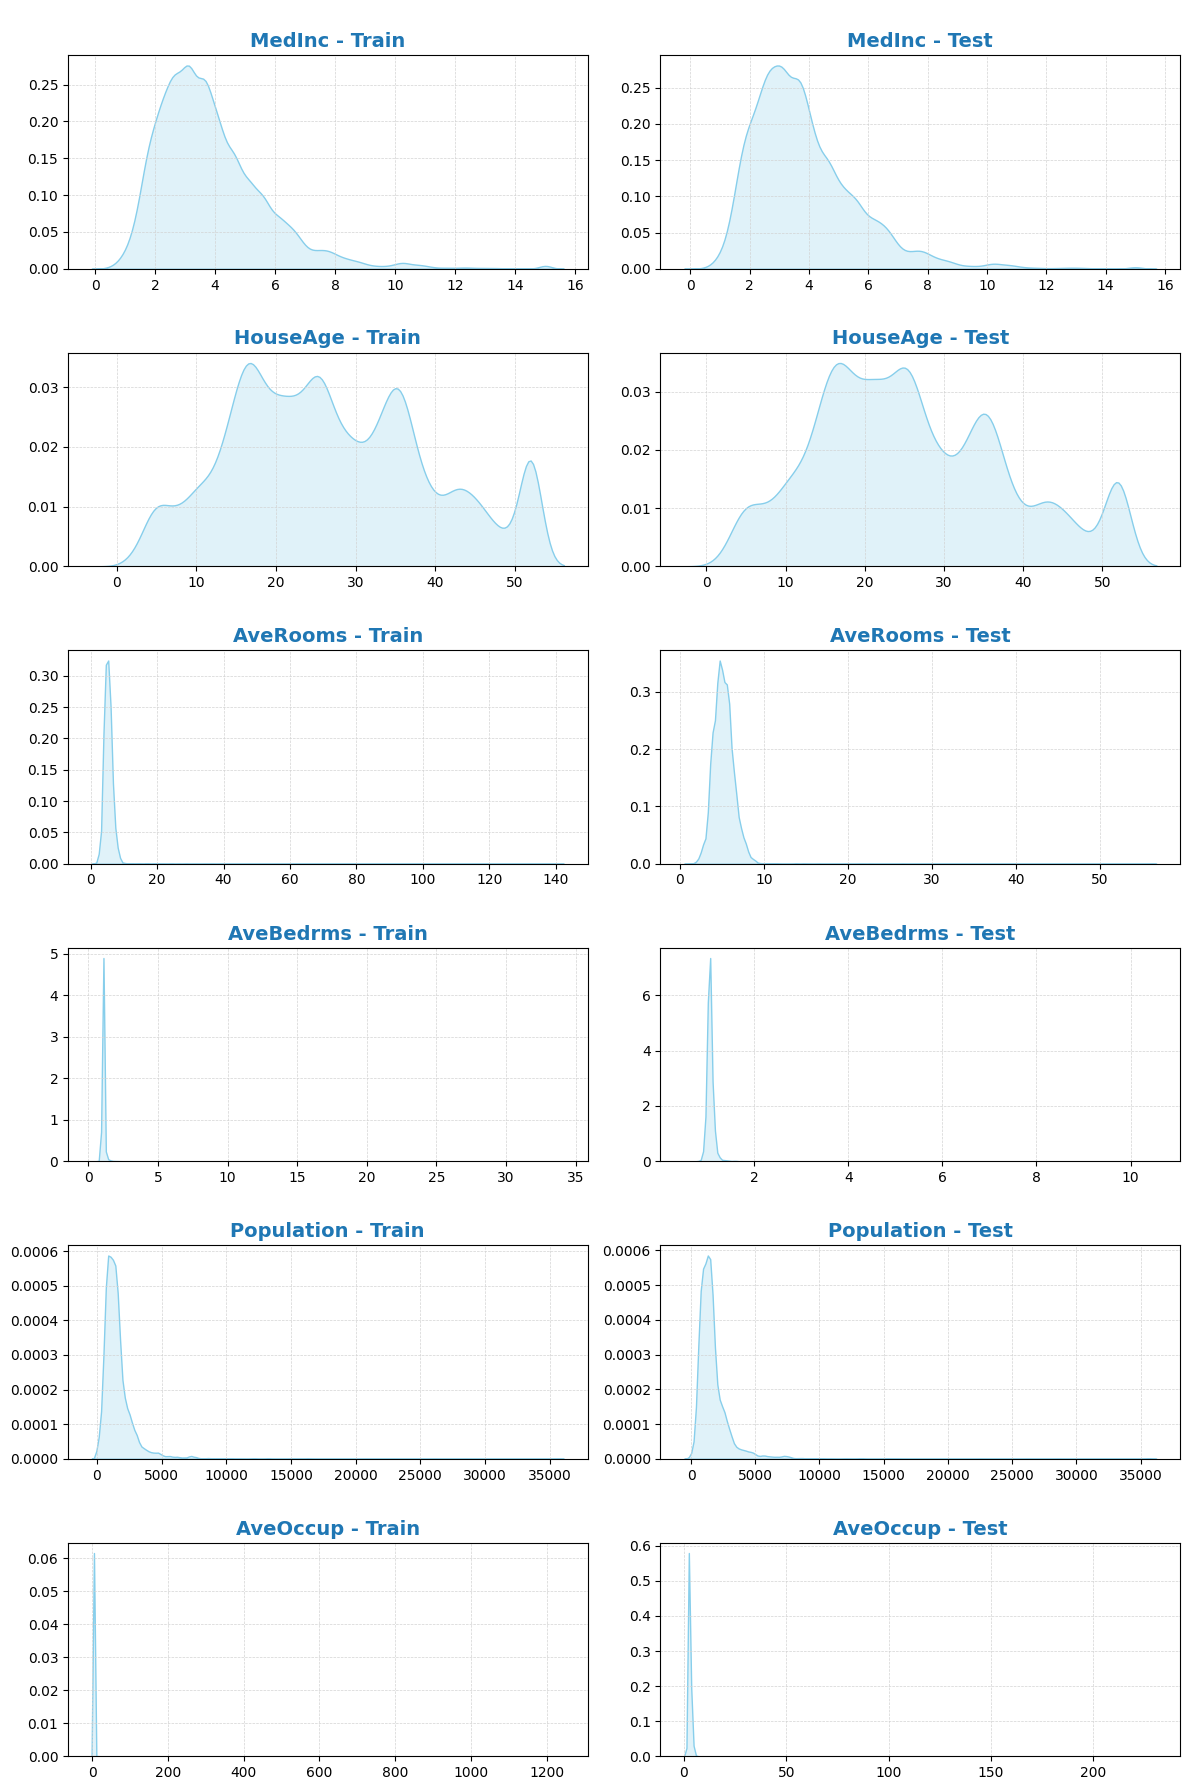

In [99]:
%%time
features_to_handle = [col for col in features if col not in ['Latitude','Longitude']]

PrintColor(f'\nFeature Distribution Analysis')
features_KDE_plot(features_to_handle, xytrain, xtest, grid_specs, title_specs)

<div style="color: #333333; 
           display: block; 
           border-radius: 12px;
           background-color: #FAFBFD; 
           font-size: 14px; 
           font-family: 'Roboto', sans-serif; 
           letter-spacing: 0.5px;
           padding: 20px; 
           border: 1px solid #CCCCCC; 
           ">
The data does not exhibit a normal distribution, indicating that some form of transformation will be necessary to improve model predictions.
</div>

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Creating a function to test Normality of all Features
</p>


In [100]:
def perform_normality_tests(features, xytrain, xtest, ad_significance_level=0.05):
    """
    Performs normality tests on given features for training and test datasets,
    and returns a DataFrame with the test results and a normality flag.
    
    Parameters:
    - features: List of feature names.
    - xytrain: DataFrame containing the training data.
    - xtest: DataFrame containing the test data.
    """
    # Preparing the DataFrame
    normal_test_results = pd.DataFrame(columns=['Source', 'Feature', 'NormalTest', 'Shapiro'])
    
    # Performing normality tests
    for col in features:
        for dataset, source in [(xytrain, 'Train'), (xtest, 'Test')]:
            row = {
                'Source': source,
                'Feature': col,
                'NormalTest': normaltest(dataset[col])[1],
                'Shapiro': shapiro(dataset[col])[1],
            }
            normal_test_results = pd.concat([normal_test_results, pd.DataFrame([row])], ignore_index=True)
            
    # Determining normality
    # [1] is the list of critical values, and [2] corresponds to a commonly used significance level, such as 5%
    normal_test_results['Is_Normal'] = np.where(
    (normal_test_results['NormalTest'] > ad_significance_level) |
    (normal_test_results['Shapiro'] > ad_significance_level), 'Y','N'
    )
    PrintColor('\nNormality test results for Train-Test data\n')
    display(normal_test_results.style.format(precision=2).applymap(
    lambda x: 'background-color: #D6EAF8; color: red; font-weight:bold' if x == 'N' else 'background-color: #EBF5FB; color: blue',
    subset=['Is_Normal']))
    return normal_test_results       

In [101]:
%%time

normal_test_results = perform_normality_tests(features_to_handle, xytrain, xtest)


Normality test results for Train-Test data



,Source,Feature,NormalTest,Shapiro,Is_Normal
0,Train,MedInc,0.00,0.00,N
1,Test,MedInc,0.00,0.00,N
2,Train,HouseAge,0.00,0.00,N
3,Test,HouseAge,0.00,0.00,N
4,Train,AveRooms,0.00,0.00,N
5,Test,AveRooms,0.00,0.00,N
6,Train,AveBedrms,0.00,0.00,N
7,Test,AveBedrms,0.00,0.00,N
8,Train,Population,0.00,0.00,N
9,Test,Population,0.00,0.00,N


CPU times: user 121 ms, sys: 1.07 ms, total: 122 ms
Wall time: 120 ms


<div style="color: #333333; 
           display: block; 
           border-radius: 12px;
           background-color: #FAFBFD; 
           font-size: 14px; 
           font-family: 'Roboto', sans-serif; 
           letter-spacing: 0.5px;
           padding: 20px; 
           border: 1px solid #CCCCCC; 
           ">
After conducting Shapiro, Anderson, and Normal tests, it has been determined that the data does not follow a normal distribution.
</div>

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
 Feature-target analysis visualization
</p>


Feature-Target interaction plots



0it [00:00, ?it/s]

CPU times: user 1.19 s, sys: 294 ms, total: 1.48 s
Wall time: 996 ms


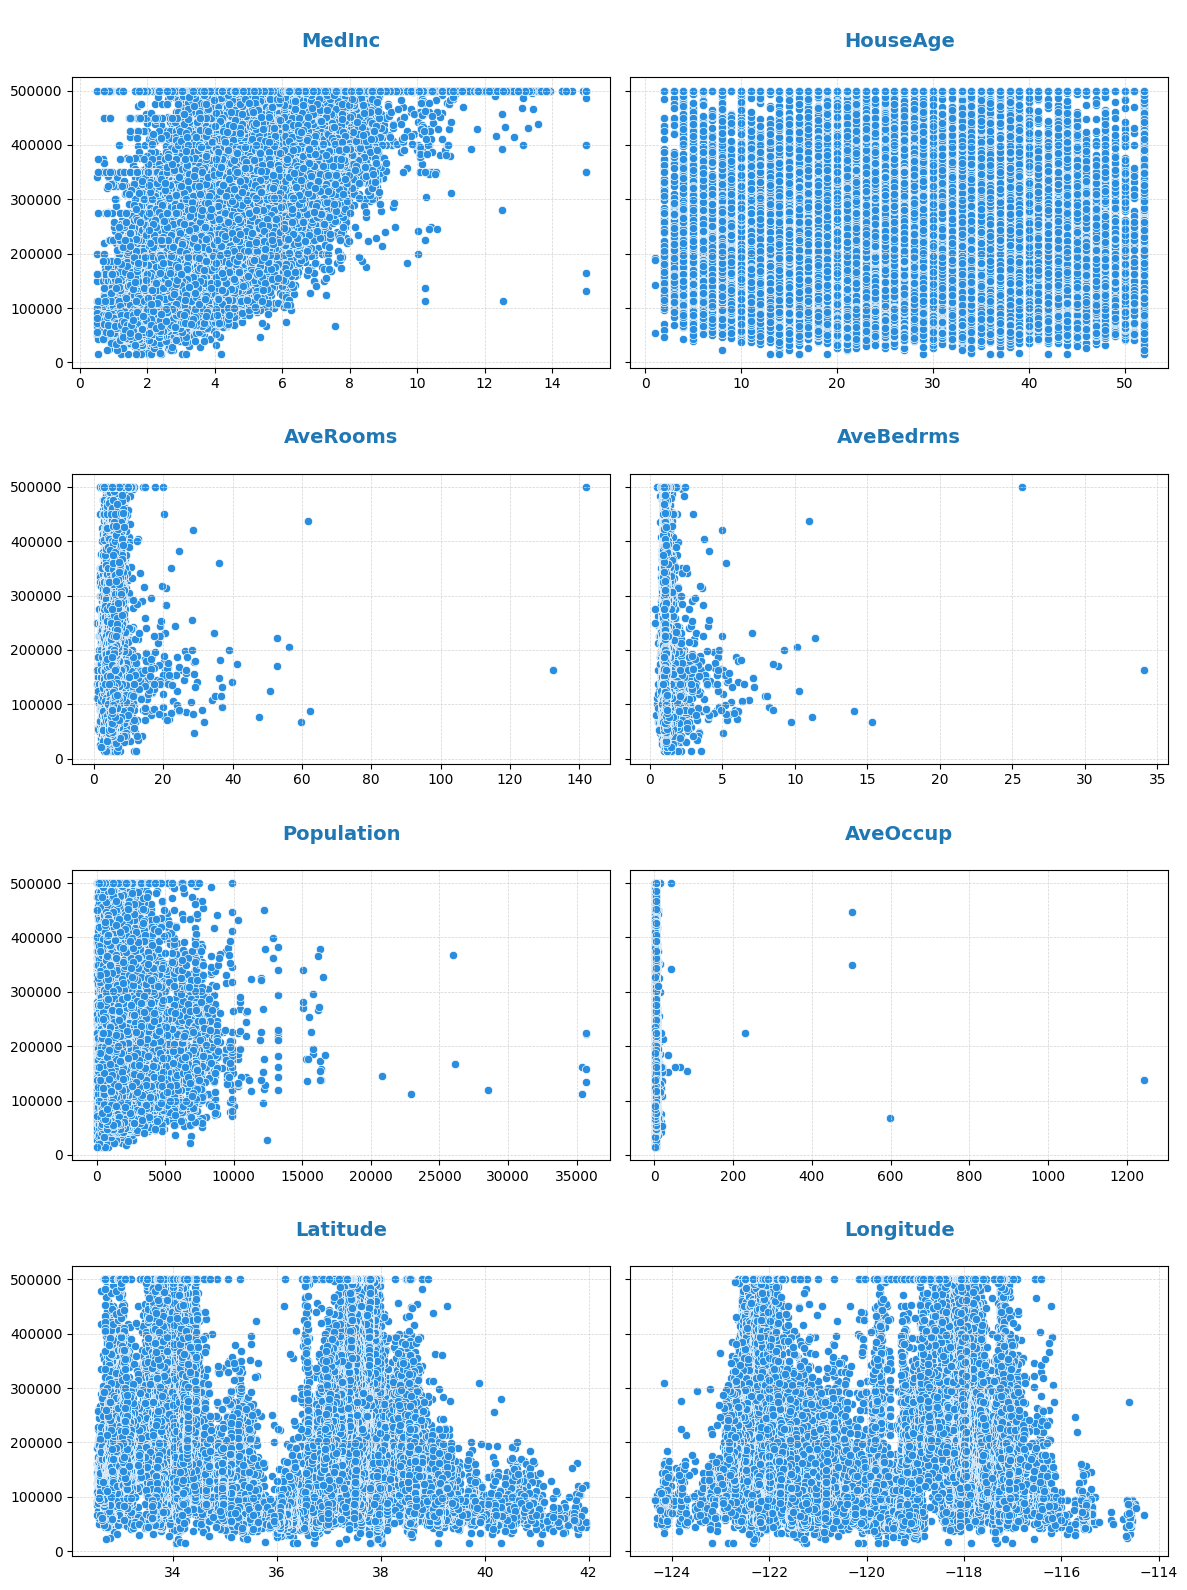

In [102]:
%%time

fig,ax = plt.subplots(4,2, figsize=(12, 2 * len(features)), sharey = True)

PrintColor(f'\nFeature-Target interaction plots\n')

for i, col in tqdm(enumerate(features)):
    # On the first iteration (i = 0), i//2 is 0, and i%2 is also 0. 
    # So, 'a' refers to the first subplot ([0, 0] - first row, first column).
    a = ax[i//2, i%2]
    sns.scatterplot(x = xytrain[col], y = xytrain[target], markers = True, ax = a, color = '#298EDF')
    a.grid(**grid_specs)
    a.set_title(f'\n{col}\n', **title_specs)
    a.set(xlabel = '', ylabel = '')
    del a
    
plt.tight_layout()

<div style="color: #333333; 
           display: block; 
           border-radius: 12px;
           background-color: #FAFBFD; 
           font-size: 14px; 
           font-family: 'Roboto', sans-serif; 
           letter-spacing: 0.5px;
           padding: 20px; 
           border: 1px solid #CCCCCC; 
           ">
The "MedInc" variable exhibits a clear positive linear correlation with the target variable. However, there are numerous outliers in the data, which will require further examination.
</div>

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Creating a function to identify outliers.
</p>

In [103]:
%%time
 
    def plot_outliers(features, xytrain, xtest, grid_specs, title_specs):
        """
        Identifies outliers using the IQR method, plots boxplots for each feature across given DataFrames,
        and counts the number of outliers in each feature.

        Parameters:
        - dataframes: List of tuples containing DataFrame and its label.
        - features: List of feature names to analyze.
        - target: Target variable name, to be excluded from the analysis.
        - title_specs: Dictionary containing title specifications.
        """
        # Calculate the number of features for plotting dimensions
        num_features = len(features)
    
        # Create a subplot grid and figure size dynamically based on the number of features
        fig, ax = plt.subplots(num_features, 2, figsize=(12, 3 * num_features))
    
    
    
        # Initialize dictionaries to store outlier counts and percentages for each dataset
        outlier_info = {'Train': {}, 'Test': {}}
        
        # Iterate through each feature to create box plots for both train and test datasets
        for i, feature in enumerate(features):
            for j, data in enumerate([xytrain, xtest]):
                sns.boxplot(data=data, x=feature, ax=ax[i,j], color='lightblue')
                ax[i,j].grid(**grid_specs)
                ax[i,j].set_title(f'\n{feature} - {"Train" if j==0 else "Test"}', **title_specs)
                ax[i,j].set(xlabel='', ylabel='')
        
            
                # Calculate outliers
                q1 = data[feature].quantile(0.25)
                q3 = data[feature].quantile(0.75)
                IQR = q3 - q1
                upper_bound = q3 + 1.5 * IQR
                lower_bound = q1 - 1.5 * IQR
            
                # Identify outliers
                is_outlier = ((data[feature] < lower_bound) | (data[feature] > upper_bound))
                count_outliers = is_outlier.sum()
                percent_outliers = (count_outliers / len(data[feature])) * 100

                # Store counts and percentages
                dataset_label = 'Train' if j == 0 else 'Test'
                outlier_info[dataset_label][feature] = (count_outliers, percent_outliers)
                
        plt.tight_layout()
         
        # Displaying outlier counts and percentages
        for dataset_label, info in outlier_info.items():
            PrintColor(f'\nNumber and percentage of outliers per Feature in the {dataset_label} dataset\n')
            outlier_df = pd.DataFrame.from_dict(info, orient='index', columns=['Outliers','Percentage'])
            display(outlier_df[outlier_df['Outliers']>0])

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.7 µs



Number and percentage of outliers per Feature in the Train dataset



,Outliers,Percentage
MedInc,1856,3.21235
AveRooms,1068,1.84849
AveBedrms,3216,5.56623
Population,3607,6.24297
AveOccup,2158,3.73505



Number and percentage of outliers per Feature in the Test dataset



,Outliers,Percentage
MedInc,804,3.24730
AveRooms,345,1.39343
AveBedrms,1091,4.40648
Population,1723,6.95909
AveOccup,950,3.83699


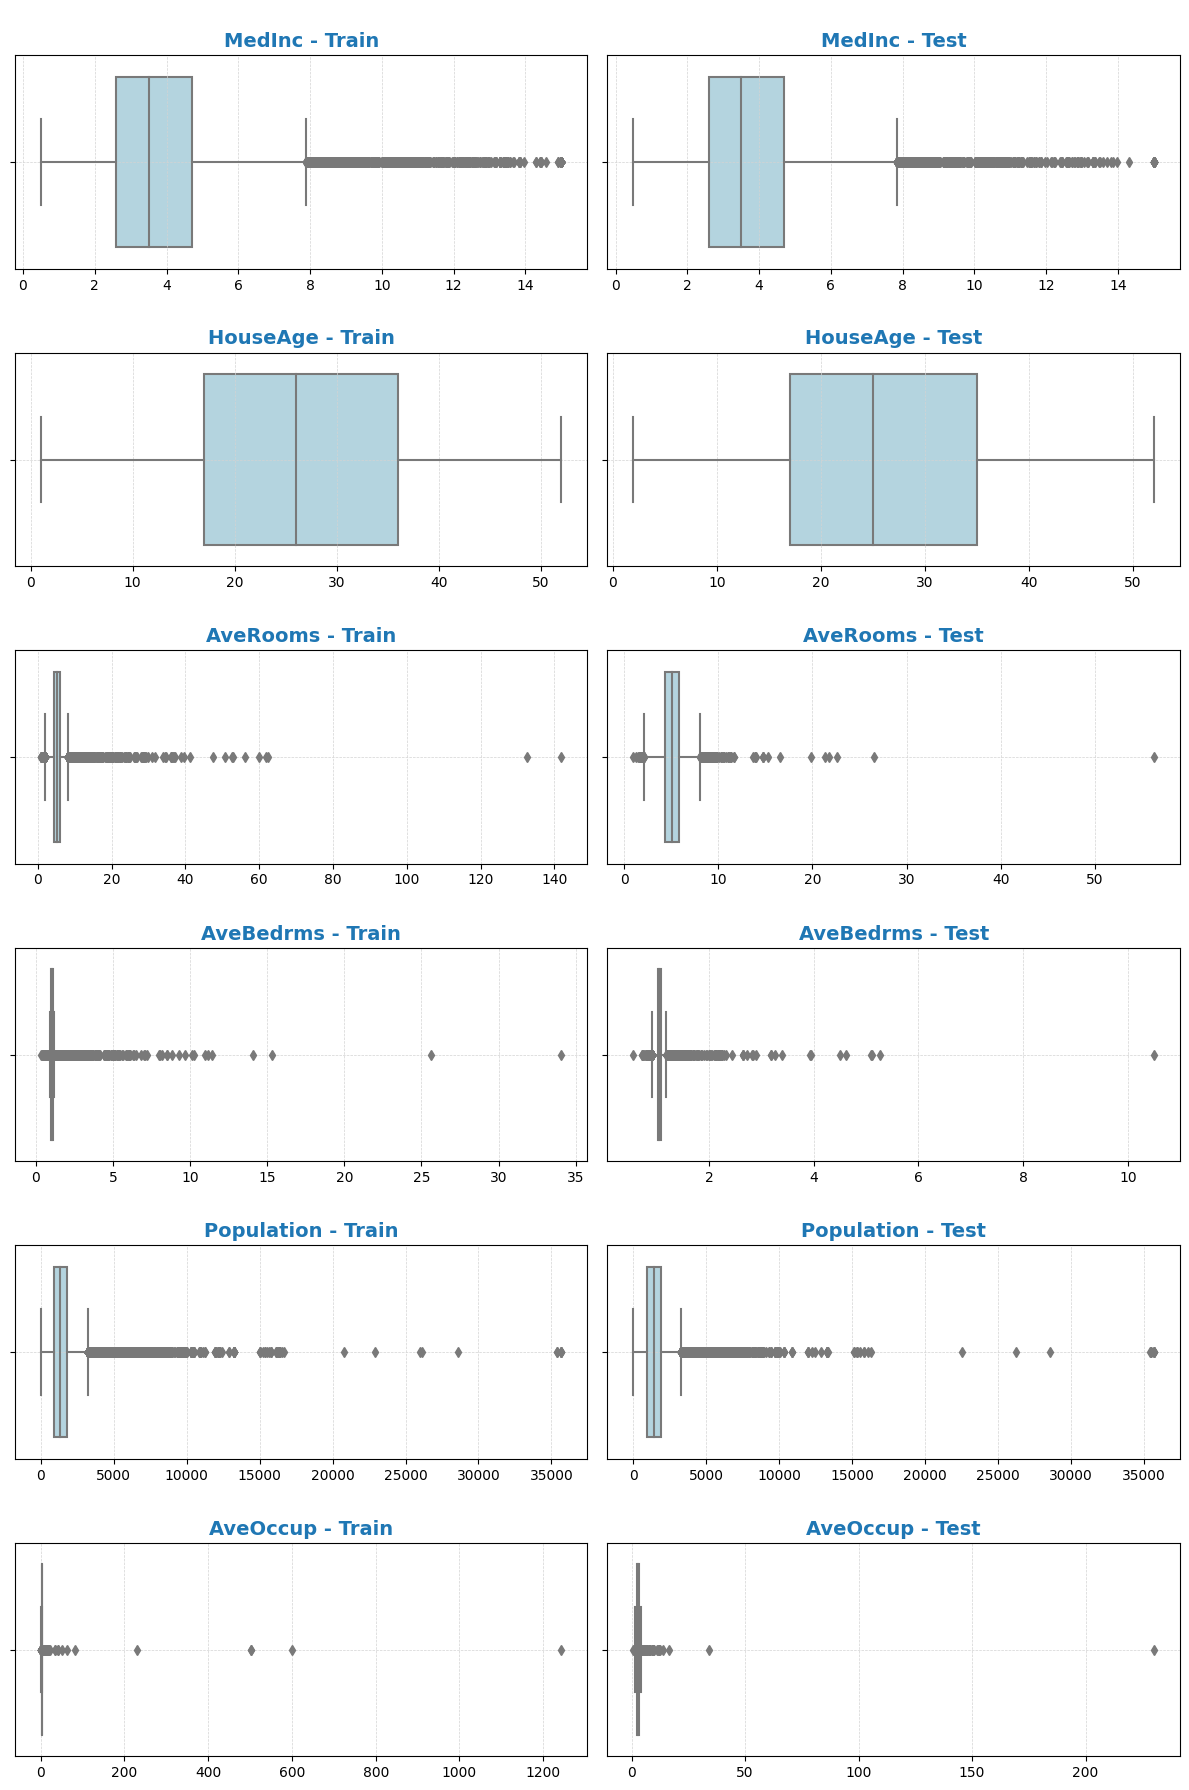

In [104]:
#analysis_features = [col for col in features if col not in ['Latitude', 'Longitude', target]]
plot_outliers(features_to_handle, xytrain, xtest, grid_specs, title_specs)

<div style="color: #333333; 
           display: block; 
           border-radius: 12px;
           background-color: #FAFBFD; 
           font-size: 14px; 
           font-family: 'Roboto', sans-serif; 
           letter-spacing: 0.5px;
           padding: 20px; 
           border: 1px solid #CCCCCC; 
           ">
Outliers are observed in nearly every column.
</div>

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Target analysis.
</p>


Studying the Target distribution



,MedHouseVal
count,"57,777.00"
mean,"207,575.27"
std,"115,692.67"
min,"14,999.00"
25%,"120,300.00"
50%,"180,400.00"
75%,"265,700.00"
max,"500,001.00"


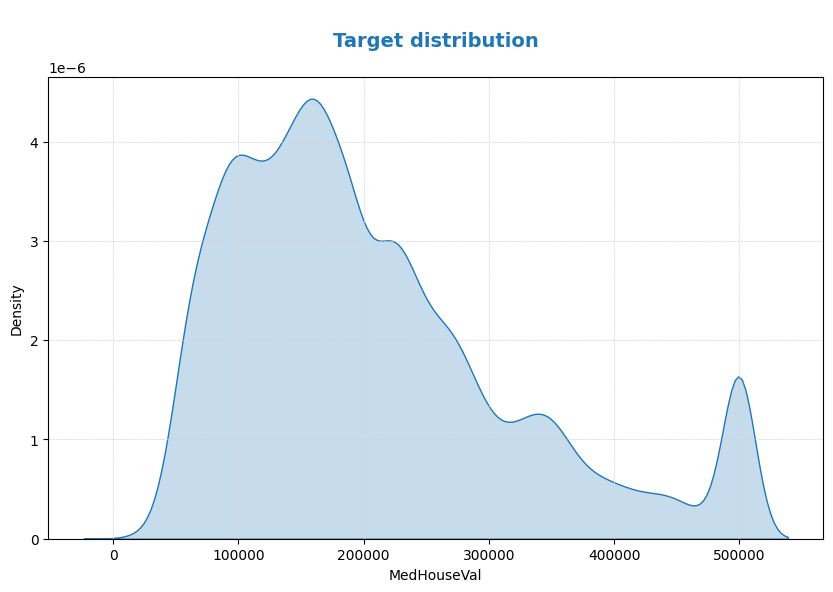


Studying Target capping at upper extremity



,MedHouseVal,0
0,"500,000.00000",73
1,"500,001.00000",2792



Studying Target capping at lower extremity



,MedHouseVal,0
0,"14,999.00000",13
1,"17,500.00000",2
2,"22,500.00000",10
3,"25,000.00000",2
4,"26,600.00000",3
...,...,...
86,"49,400.00000",14
87,"49,500.00000",14
88,"49,600.00000",3
89,"49,800.00000",16


In [105]:
# Analyzing potential Target capping
PrintColor(f'\nStudying the Target distribution\n')
display(xytrain[[target]].describe().style.format(formatter = '{:,.2f}'))

# Target KDE Plot
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.kdeplot(data=xytrain, x = target, ax = ax, color='tab:blue', fill = True)
ax.grid(**grid_specs)
ax.set_title(f'\nTarget distribution\n', **title_specs)
plt.show()
del fig, ax

PrintColor(f'\nStudying Target capping at upper extremity\n')
display(xytrain.loc[xytrain[target] >= 500_000].groupby(xytrain[target]).size().reset_index())

PrintColor(f'\nStudying Target capping at lower extremity\n')
display(xytrain.loc[xytrain[target] <= 50_000].groupby(xytrain[target]).size().reset_index())

<div style="color: #333333; 
           display: block; 
           border-radius: 12px;
           background-color: #FAFBFD; 
           font-size: 14px; 
           font-family: 'Roboto', sans-serif; 
           letter-spacing: 0.5px;
           padding: 20px; 
           border: 1px solid #CCCCCC; 
           ">
I won't perform any transformation on the target since it exhibits an almost normal distribution, although there's a noticeable concentration of higher values near the upper limit.
</div>

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 22px; text-align: left; padding: 10px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Key notes from preliminary EDA
</p>

<div style="color: #333333; 
           display: block; 
           border-radius: 12px;
           background-color: #FAFBFD; 
           font-size: 14px; 
           font-family: 'Roboto', sans-serif; 
           letter-spacing: 0.5px;
           padding: 20px; 
           border: 1px solid #CCCCCC; 
           ">
 <ul style="list-style-type: disc; padding-left: 20px; margin: 0;">
        <li>Upon analyzing the dataset, it's evident that both features and the target variable exhibit non-normal distributions. This necessitates exploring methods to transform the data for improved model performance.</li>
        <li>The dataset contains numerical features with no null values.</li>
        <li>The target variable is capped at 500,010 in 2792 instances.</li>
        <li>Outliers are present in almost all the features, requiring the use of techniques like the interquartile range (IQR) method for treatment.</li>
        <li>A notable linear relationship is observed between the target variable and median income.</li>
    </ul>
</div>

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Feature Engineering
</p>

In [106]:
xytrain['RoomBedRat'] = xytrain['AveRooms'] / xytrain['AveBedrms'] # Indicates the proportion of rooms that are bedrooms
xtest['RoomBedRat'] = xtest['AveRooms'] / xtest['AveBedrms']

xytrain['BedrmsPerRoom'] = xytrain['AveBedrms'] / xytrain['AveRooms'] # Indicates the proprotion of bedrooms that are rooms
xtest['BedrmsPerRoom'] = xtest['AveBedrms'] / xtest['AveRooms']

xytrain['PopPerHousehold'] = xytrain['Population'] / xytrain['AveOccup'] # Indicates the average number of individuals per haushold
xtest['PopPerHousehold'] = xtest['Population'] / xtest['AveOccup']

xytrain['IncomePerRoom'] = xytrain['MedInc'] / xytrain['AveRooms'] # Indicates insight into the income distribution relative to the size of rooms
xtest['IncomePerRoom'] = xtest['MedInc'] / xtest['AveRooms']

xytrain['IncPopRat'] = xytrain['MedInc'] / xytrain['Population'] #  Indicates insight into the income distribution relative to the size of the population in the area
xtest['IncPopRat'] = xtest['MedInc'] / xtest['Population']

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Outlier Handling
</p>

In [107]:
def handle_outliers_iqr(df, features):
    """
    Handles outliers in the specified features of a DataFrame based on the IQR method.
    
    Parameters:
    - df: pandas DataFrame containing the data.
    - features: List of column names (strings) in df for which outliers should be handled.

    Returns:
    - A DataFrame with outliers handled in the specified features.
    """
    for feature in features:
        q1 = df[feature].quantile(0.25)
        q3 = df[feature].quantile(0.75)
        IQR = q3 - q1
        
        lower_bound = q1 - 1.5 * IQR
        upper_bound = q3 + 1.5 * IQR
        
        # Capping the values outside the inner fences
        df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
        df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])
        
    return df

In [108]:
%%time

features_to_handle = [col for col in xytrain.columns if col not in ['Latitude', 'Longitude', target]]

train_iqr = handle_outliers_iqr(xytrain.copy(), features_to_handle)
test_iqr = handle_outliers_iqr(xtest.copy(), features_to_handle)

CPU times: user 94.2 ms, sys: 2.81 ms, total: 97 ms
Wall time: 96.4 ms


<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Handling Skewness
</p>

In [109]:
def handle_non_normality(df, features, method='box-cox'):
    """
    Applies a power transformation (Box-Cox or Yeo-Johnson) to reduce non-normality in specified features of a DataFrame.
    
    Parameters:
    - df: pandas DataFrame containing the data.
    - features: List of column names (strings) in df for which non-normality should be reduced.
    - method: Transformation method to use ('box-cox' for strictly positive features or 'yeo-johnson' for features with any values).

    Returns:
    - A DataFrame with non-normality handled in the specified features.
    """   
    pt = PowerTransformer(method=method, standardize=False) # standardize=False to only apply transformation without scaling
    
    # Fit and transform the specified features
    transformed_features = pt.fit_transform(df[features])
    
    # Update the DataFrame with transformed data
    df[features] = transformed_features
    
    return df

In [110]:
train_pt = handle_non_normality(train_iqr.copy(), features_to_handle, method='box-cox')
test_pt = handle_non_normality(test_iqr.copy(), features_to_handle, method='box-cox')

In [111]:
normal_test_results = perform_normality_tests(features_to_handle, train_pt, test_pt)


Normality test results for Train-Test data



,Source,Feature,NormalTest,Shapiro,Is_Normal
0,Train,MedInc,0.00,0.00,N
1,Test,MedInc,0.00,0.00,N
2,Train,HouseAge,0.00,0.00,N
3,Test,HouseAge,0.00,0.00,N
4,Train,AveRooms,0.62,0.00,Y
5,Test,AveRooms,0.04,0.00,N
6,Train,AveBedrms,0.00,0.00,N
7,Test,AveBedrms,0.00,0.00,N
8,Train,Population,0.07,0.00,Y
9,Test,Population,0.08,0.00,Y



Feature Distribution Analysis
CPU times: user 9.72 s, sys: 5.52 s, total: 15.2 s
Wall time: 6.73 s


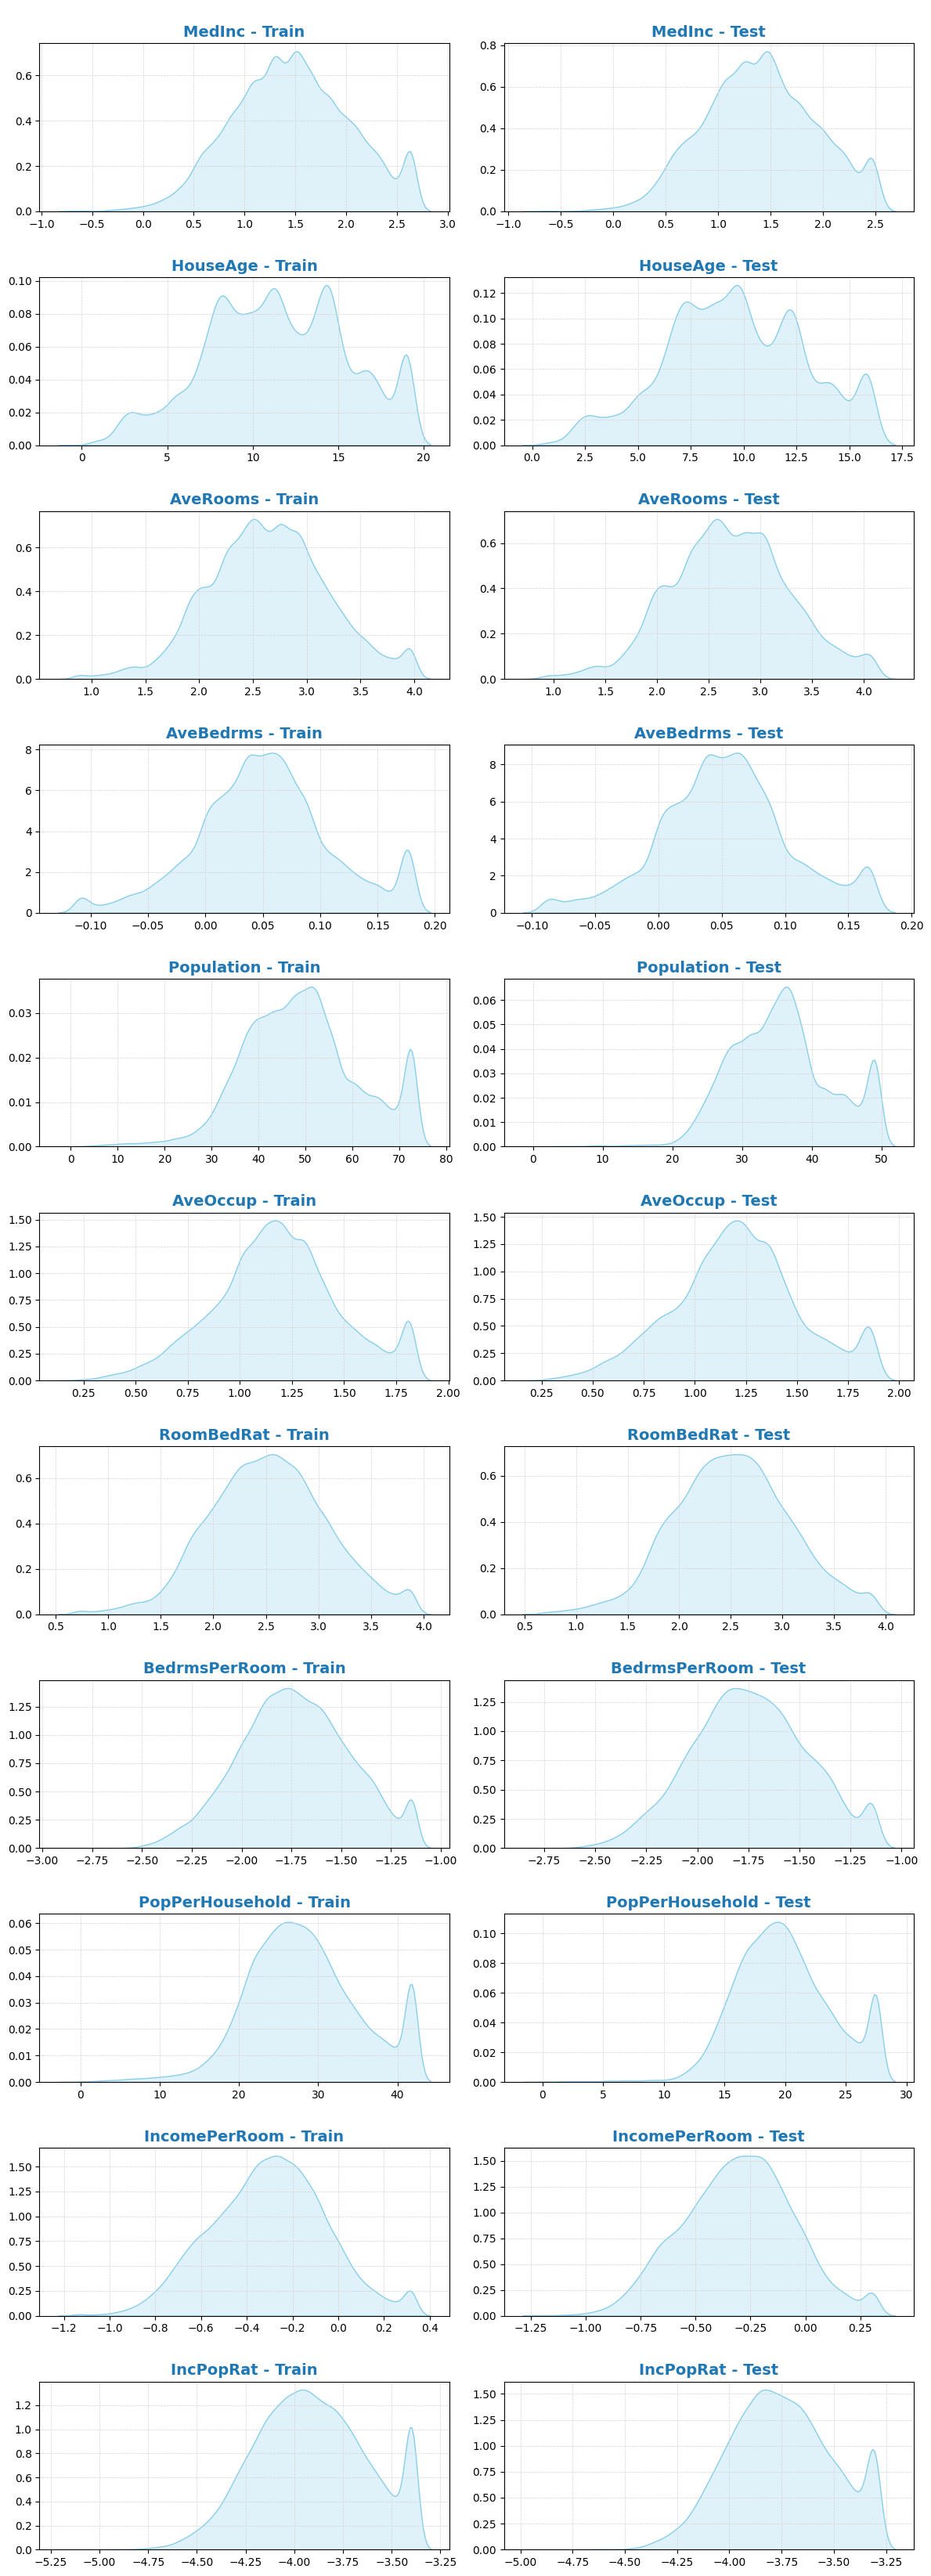

In [112]:
%%time
PrintColor(f'\nFeature Distribution Analysis')
features_KDE_plot(features_to_handle, train_pt, test_pt, grid_specs, title_specs)

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Defining Train, Test, and Target
</p>

<div style="color: #333333; 
           display: block; 
           border-radius: 12px;
           background-color: #FAFBFD; 
           font-size: 14px; 
           font-family: 'Roboto', sans-serif; 
           letter-spacing: 0.5px;
           padding: 20px; 
           border: 1px solid #CCCCCC; 
           ">
As the Kaggle test dataset does not include the target variable, I will proceed with only the training dataset. I will partition the training dataset into training and validation subsets for use in a nested grid search and cross-validation loop. Additionally, I will set aside a test set from the training dataset to be used for final predictions.
</div>

In [113]:
target = xytrain['MedHouseVal']

train = train_pt.drop(['Latitude','Longitude','MedHouseVal'],axis=1)

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Splitting the data
</p>

In [114]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=16)

PrintColor(f"Training set size: {X_train.shape[0]} samples")

PrintColor(f"Test set size: {X_test.shape[0]} samples")

Training set size: 46221 samples
Test set size: 11556 samples


<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Feature Scaling
</p>

In [115]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training set only
scaler.fit(X_train)

# Transform the training, validation, and test sets
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

# If you need to convert the scaled arrays back to DataFrames
train_scaled_df = pd.DataFrame(X_train_scaled, columns = train.columns)

test_scaled_df = pd.DataFrame(X_test_scaled, columns = train.columns)

# 'train_standard_df' and 'test_standard_df' are now your scaled features DataFrames for training and testing, respectively.

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Feature Correlation Exploration
</p>

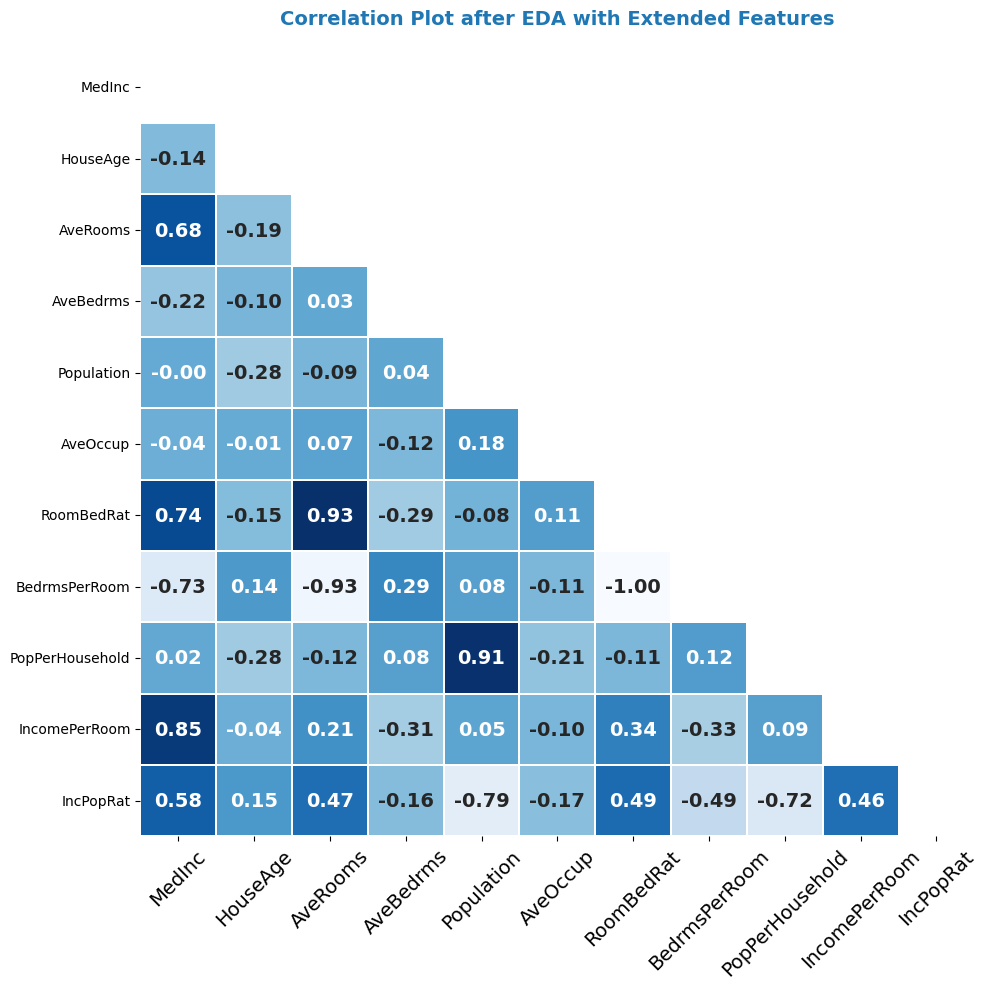

In [116]:
# Compute the correlation matrix
corr_matrix = train_scaled_df.corr()

# generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(corr_matrix, mask=mask, cmap='Blues', annot=True, fmt='.2f',
            annot_kws={'fontweight':'bold', 'fontsize':14},
            linewidth=1.25, linecolor='white', cbar=False, ax=ax)

plt.xticks(rotation=45)
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labels, fontsize=14)
ax.set_title("Correlation Plot after EDA with Extended Features", pad=20, **title_specs)

plt.tight_layout()

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Selecting Highly Correlated Variables
</p>

In [117]:
# Define a high correlation threshold
threshold = 0.75

# Find features that are highly correlated
# We use np.triu to consider only the upper part of the correlation matrix and avoid duplication
high_corr_var = np.where(abs(corr_matrix) >= threshold)
high_corr_var = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]

# Print the pairs of highly correlated features
PrintColor(f'\nHighly correlated variables:\n', color='red')
for var_pair in high_corr_var:
    PrintColor(f'{var_pair}')


Highly correlated variables:

('MedInc', 'IncomePerRoom')
('AveRooms', 'RoomBedRat')
('AveRooms', 'BedrmsPerRoom')
('Population', 'PopPerHousehold')
('Population', 'IncPopRat')
('RoomBedRat', 'BedrmsPerRoom')


<div style="color: #333333; 
           display: block; 
           border-radius: 12px;
           background-color: #FAFBFD; 
           font-size: 14px; 
           font-family: 'Roboto', sans-serif; 
           letter-spacing: 0.5px;
           padding: 20px; 
           border: 1px solid #CCCCCC; 
           ">
In pairs of highly correlated variables, one variable often emerges through feature engineering. This is an expected outcome, as new features are typically derived from ratios or combinations of the original features.
</div>

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Mutual Information Exploration
</p>

In [118]:
def calculate_mi_scores(data, target, random_state=16):
    """
    Calculates and returns the mutual information scores between each feature in X and the target y.
    
    Parameters:
    - X: DataFrame containing the features.
    - y: Series containing the target variable.
    - random_state: int, RandomState instance 
    
    Returns:
    - A sorted DataFrame with the mutual information scores for each feature.
    """
    mi_scores = mutual_info_regression(data, target, random_state=random_state)
    mi_scores = pd.DataFrame(data=mi_scores, index=data.columns, columns=['MI Scores'])
    mi_scores = mi_scores.sort_values(by='MI Scores', ascending=False)
    return(mi_scores)

In [119]:
mi_scores = calculate_mi_scores(train_scaled_df, y_train)
display(mi_scores)

,MI Scores
MedInc,0.43024
IncomePerRoom,0.40758
BedrmsPerRoom,0.15777
RoomBedRat,0.14445
AveRooms,0.13216
IncPopRat,0.12802
AveOccup,0.08236
HouseAge,0.05266
Population,0.04567
AveBedrms,0.03173


<div style="color: #333333; 
           display: block; 
           border-radius: 12px;
           background-color: #FAFBFD; 
           font-size: 14px; 
           font-family: 'Roboto', sans-serif; 
           letter-spacing: 0.5px;
           padding: 20px; 
           border: 1px solid #CCCCCC; 
           ">
In the context of feature selection in machine learning, the mutual information score quantifies the dependency between each feature in the dataset and the target variable. Higher scores indicate stronger relationships, making those features more valuable for prediction.
</div>

In [120]:
def calculate_vif(features):
    """
    Calculates the Variance Inflation Factor (VIF) for each feature in a DataFrame.

    Parameters:
    - df_features: A pandas DataFrame where each column represents a feature. Should not include the target variable.

    Returns:
    - A DataFrame with two columns: 'Feature' and 'VIF', sorted by VIF in descending order.
    """
    # Add a constant term for the intercept (required for VIF calculation)
    X_const = add_constant(features)
    
    # Create VIF DataFrame
    vif_df = pd.DataFrame({
        'Feature': X_const.columns,
        'VIF': [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
    })
    vif_df = vif_df.sort_values(by='VIF', ascending=False).reset_index(drop=True)
    
    return vif_df

<div style="color: #333333; 
           display: block; 
           border-radius: 12px;
           background-color: #FAFBFD; 
           font-size: 14px; 
           font-family: 'Roboto', sans-serif; 
           letter-spacing: 0.5px;
           padding: 20px; 
           border: 1px solid #CCCCCC; 
           ">
<p><strong>Variance Inflation Factor (VIF)</strong> measures the increase in the variance of the coefficient estimates if predictors are correlated, indicating multicollinearity. A VIF of 1 suggests no correlation.</p>
    <ul>
        <li><strong>VIF = 1</strong>: No correlation.</li>
        <li><strong>VIF 1-5</strong>: Moderate correlation.</li>
        <li><strong>VIF ≥ 5</strong>: High multicollinearity.</li>
    </ul> 
</div>

In [121]:
vif_df = calculate_vif(train_scaled_df)
display(vif_df)

,Feature,VIF
0,RoomBedRat,139.67004
1,BedrmsPerRoom,112.52031
2,Population,62.75701
3,PopPerHousehold,56.12798
4,MedInc,52.19531
5,AveRooms,37.01954
6,IncPopRat,26.56792
7,IncomePerRoom,24.94523
8,AveOccup,9.55140
9,AveBedrms,3.98009


<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Choosing Features between Mutual Information and VIF Score
</p>

In [122]:
# Select features with high MI scores (threshold can be adjusted based on distribution of your MI scores)
selected_features = mi_scores[mi_scores['MI Scores'] > 0.1].index.tolist()

# Filter out features with high VIF values from the selected features
final_features = [feature for feature in selected_features if feature in vif_df[vif_df['VIF'] < 30]['Feature'].values]

# Print the pairs of highly correlated features
PrintColor(f'\nFeatures selected based on a combination of mutual information and VIF score:\n', color='black')
for feature in final_features:
    PrintColor(f'\n{feature}')


Features selected based on a combination of mutual information and VIF score:


IncomePerRoom

IncPopRat


<div style="color: #333333; 
           display: block; 
           border-radius: 12px;
           background-color: #FAFBFD; 
           font-size: 14px; 
           font-family: 'Roboto', sans-serif; 
           letter-spacing: 0.5px;
           padding: 20px; 
           border: 1px solid #CCCCCC; 
           ">
By employing a combination of mutual information and VIF score to select features, only two potentiated features were identified. Given the relatively small number of original features and the limited number of new features derived through feature engineering (only 5), the model construction will proceed using all features. We initiate our modeling strategy with Ridge regression, specifically selected for its proficiency in preventing overfitting. It achieves this by diminishing the influence of features deemed less essential, ensuring their continued presence in the model but with moderated significance. 
</div>

In [123]:
# Initialize cross-validation schemes
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Creating a function for model creation and evaluation.
</p>

In [124]:
def model_optimization_and_evaluation(model, param_grid, train_data, target_data, inner_cv, outer_cv):
    """
    Performs model optimization using GridSearchCV and evaluates the model using nested cross-validation.
    
    Parameters:
    - model: The machine learning model to be optimized and evaluated.
    - param_grid: The parameter grid for the model's hyperparameters.
    - train_data: Feature data for training.
    - target_data: Target data.
    - inner_cv: Cross-validation splitting strategy for GridSearchCV.
    - outer_cv: Cross-validation splitting strategy for evaluating the optimized model.
    
    Returns:
    - grid_search_best_model: The GridSearchCV object after fitting to the entire dataset.
    - cross_validated_scores: The results from the nested cross-validation.
    """
    # Initialize the GridSearchCV object
    grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=-1, cv=inner_cv)
    
    # Perform nested cross-validation
    cross_validated_scores = cross_validate(grid_search, train_data, target_data, cv=outer_cv, return_estimator=True, return_train_score=True, n_jobs=-1)
    
    # Fit the GridSearchCV object 
    grid_search_best_model = grid_search.fit(train_data, target_data)
    
    return grid_search_best_model, cross_validated_scores

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Defining the Model.
</p>

In [125]:
%%time

model_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2)),  # Generate polynomial features
    ('ridge', Ridge())  # Apply Ridge regression
])

param_grid = {
    "ridge__alpha": (np.linspace(0.01, 1000, 10))
}

grid_search_ridge, cv_scores_ridge = model_optimization_and_evaluation(model_pipeline, param_grid, train_scaled_df, y_train, inner_cv, outer_cv)

CPU times: user 429 ms, sys: 187 ms, total: 616 ms
Wall time: 14.4 s


<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
Creating a DataFrame with Inner CV results
</p>

In [126]:
# Represents the process of hyperparameter optimization. It does not directly contain model performance metrics,
# but holds the best model parameters after fitting to data.
# Define the columns to extract from cv_results and prepare for renaming mean_test_score
columns = [f'param_{name}' for name in param_grid.keys()] + ['mean_test_score']

# Directly construct the DataFrame list using a comprehension
# Rename the 'mean_test_score' column within the comprehension for clarity
inner_cv_results = [
    pd.DataFrame(estimator.cv_results_)[columns]
    .set_index([f'param_{name}' for name in param_grid.keys()])
    .rename(columns={'mean_test_score': f'CV {cv_idx + 1} mean_test_score'})
    for cv_idx, estimator in enumerate(cv_scores_ridge['estimator'])
]

# Concatenate the list of DataFrames along the columns and transpose for a better layout
inner_cv_results_df = pd.concat(inner_cv_results, axis=1)
# Display the combined DataFrame
display(inner_cv_results_df.style.format("{:.5f}"))

,CV 1 mean_test_score,CV 2 mean_test_score,CV 3 mean_test_score,CV 4 mean_test_score,CV 5 mean_test_score
param_ridge__alpha,,,,,
0.010000,0.65023,0.65116,0.64704,0.64978,0.64984
111.120000,0.65084,0.65184,0.64733,0.65055,0.65005
222.230000,0.65062,0.65163,0.64706,0.65037,0.64973
333.340000,0.65039,0.65139,0.64679,0.65013,0.64942
444.450000,0.65017,0.65116,0.64654,0.64990,0.64914
555.560000,0.64996,0.65093,0.64631,0.64967,0.64887
666.670000,0.64976,0.65072,0.64609,0.64945,0.64863
777.780000,0.64957,0.65051,0.64588,0.64924,0.64840
888.890000,0.64939,0.65032,0.64568,0.64903,0.64818


<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
Plotting Inner CV Results Across Different Alpha Values
</p>

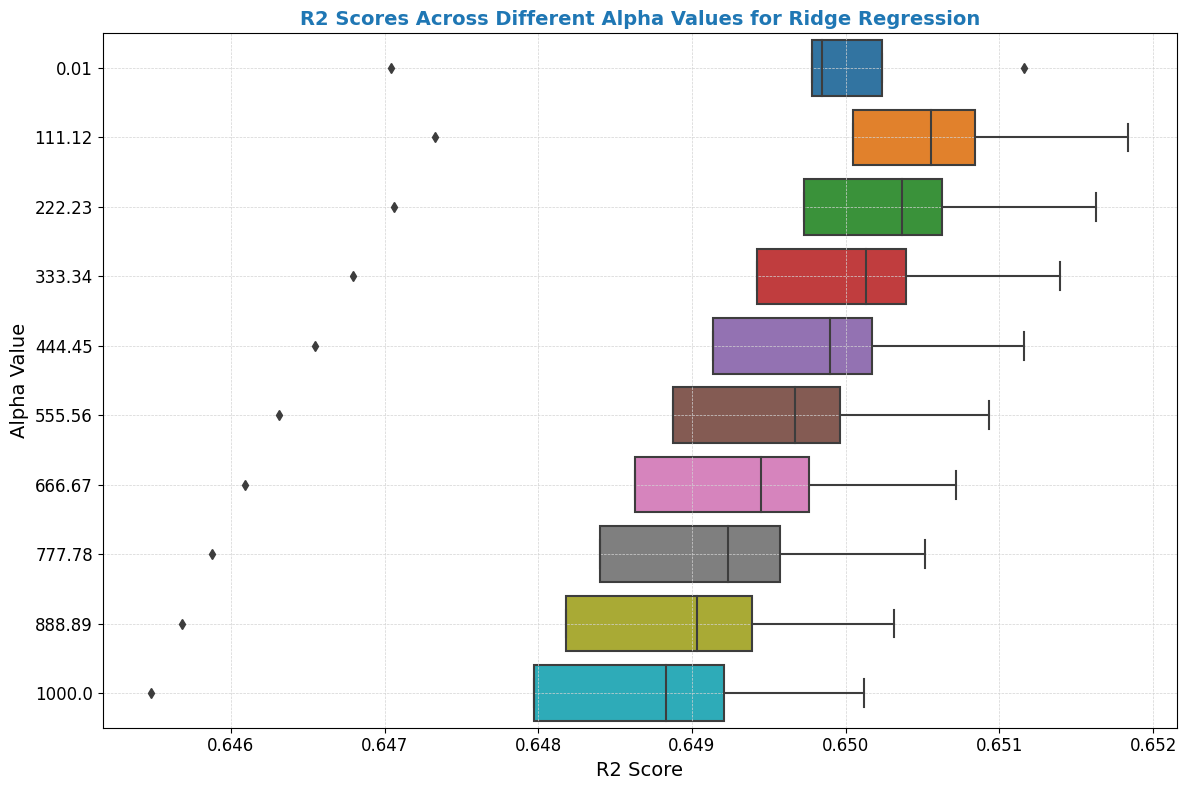

In [127]:
inner_cv_melted = inner_cv_results_df.reset_index()
# Melting the DataFrame to long format
inner_cv_melted = pd.melt(inner_cv_melted, id_vars=['param_ridge__alpha'], var_name='CV Fold', value_name='R2 Score')

plt.figure(figsize=(12, 8))  
sns.boxplot(data=inner_cv_melted, y='param_ridge__alpha', x='R2 Score', orient='h')

# Setting the labels and title
plt.xlabel('R2 Score', fontsize=14)
plt.ylabel('Alpha Value', fontsize=14)
plt.title('R2 Scores Across Different Alpha Values for Ridge Regression', **title_specs)

# Optionally, adjust tick parameters for readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show grid lines for better readability
plt.grid(**grid_specs)

plt.tight_layout()  # Adjust layout to make room for the tick labels

<div style="color: #333333; 
           display: block; 
           border-radius: 12px;
           background-color: #FAFBFD; 
           font-size: 14px; 
           font-family: 'Roboto', sans-serif; 
           letter-spacing: 0.5px;
           padding: 20px; 
           border: 1px solid #CCCCCC; 
           ">
 <ul style="list-style-type: disc; padding-left: 20px; margin: 0;">
        <li style="margin-bottom: 10px;">The best mean test scores across the five cross-validation folds were observed for alpha values around 111.12, indicating this level of regularization optimizes the trade-off between bias and variance for this dataset. Beyond this alpha value, the mean test scores tend to slightly decrease, suggesting that too much regularization may start to detrimentally affect the model's ability to capture the underlying data pattern.</li>
        <li style="margin-bottom: 10px;">The scores are relatively stable across different CV folds for each alpha value, suggesting that the model is consistent and not overly sensitive to the specific subsets of data used in each fold.</li>
    </ul>
</div>

In [128]:
scores = pd.DataFrame(cv_scores_ridge)
display(scores)

,fit_time,score_time,estimator,test_score,train_score
0,7.68228,0.01679,"GridSearchCV(cv=KFold(n_splits=5, random_state...",0.64718,0.65326
1,7.90891,0.03747,"GridSearchCV(cv=KFold(n_splits=5, random_state...",0.64392,0.65407
2,7.80096,0.02057,"GridSearchCV(cv=KFold(n_splits=5, random_state...",0.66091,0.64989
3,7.66680,0.01838,"GridSearchCV(cv=KFold(n_splits=5, random_state...",0.64874,0.65278
4,2.17059,0.01265,"GridSearchCV(cv=KFold(n_splits=5, random_state...",0.65191,0.65213


<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
Ridge Scores - Outer Loop
</p>

In [129]:
# Represents the evaluation of the Ridge regression model across multiple splits of the data, 
# with hyperparameter tuning performed within each split of the outer cross-validation loop

scores = pd.DataFrame(cv_scores_ridge)

# Train error

train_error = scores["train_score"]
PrintColor(f"\nR2 of Ridge Regressor model on the Train set:\n"
      f"\n{train_error.mean():.5f} with a Standard Deviation of +/- {train_error.std():.5f}\n")

display(scores["train_score"].to_frame())


R2 of Ridge Regressor model on the Train set:

0.65242 with a Standard Deviation of +/- 0.00159



,train_score
0,0.65326
1,0.65407
2,0.64989
3,0.65278
4,0.65213


In [130]:
# Test Error

test_error = scores["test_score"]
PrintColor(f"\nR2 of Ridge Regressor model on the Test set:\n"
      f"\n{test_error.mean():.5f} with a Standard Deviation of +/- {test_error.std():.5f}\n")

display(scores["test_score"].to_frame())


R2 of Ridge Regressor model on the Test set:

0.65053 with a Standard Deviation of +/- 0.00648



,test_score
0,0.64718
1,0.64392
2,0.66091
3,0.64874
4,0.65191


<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
Model Parameters
</p>

In [131]:
# Retrieve the best hyperparameters for the Ridge model
best_params = grid_search_ridge.best_params_

# Print the best parameters
PrintColor(f'\nBest Parameters: {best_params}\n')

# For example, if your Ridge model is named 'ridge' in the pipeline:
if 'ridge' in model_pipeline.named_steps:
    best_ridge_model = grid_search_ridge.best_estimator_.named_steps['ridge']
    best_coefs = best_ridge_model.coef_

    # best_coefs now contains the coefficients of the best Ridge model
    print(f'\nBest Coefficients:\n, {best_coefs}')


Best Parameters: {'ridge__alpha': 111.12}


Best Coefficients:
, [ 0.00000000e+00  4.60273246e+04  1.81641022e+04  1.17413138e+04
  6.55100351e+03 -5.92669163e+02 -2.41514226e+04 -4.15266933e+03
  6.57804453e+03  7.96073347e+03  3.55052888e+04  5.82782681e+03
  1.94455785e+04  1.96501924e+04 -1.19627347e+04  1.62646498e+04
 -1.28557900e+03 -1.81048431e+04 -2.13309155e+03  6.96893458e+03
  1.18257023e+04 -3.63111492e+03  1.01810538e+04  1.83120336e+03
 -4.07247656e+03 -1.57326644e+03  3.52018875e+03 -3.06544873e+03
 -5.33775302e+03  1.89976635e+03  6.95407506e+03 -1.26788234e+04
  1.06031117e+04  3.51956675e+03 -5.00156658e+03  4.08135869e+03
  1.00298664e+04  6.36109998e+03 -4.99173904e+03 -6.10796554e+02
  9.65903102e+02 -3.70360106e+02 -1.23434180e+03  3.80084904e+03
 -2.18773370e+03 -6.44579397e+03 -5.57946805e+03 -2.31729005e+03
 -1.07150918e+04  4.25596131e+03  1.29057691e+03 -1.84649144e+02
 -1.85163528e+03  9.45169432e+02  1.31631964e+03  2.16713513e+03
 -4.37580865e+03  9.7814

In [132]:
best_model_pipeline = grid_search_ridge.best_estimator_

# Extracting the polynomial feature transformer and Ridge model from the best pipeline
poly_transformer = best_model_pipeline.named_steps['poly_features']
ridge_model = best_model_pipeline.named_steps['ridge']

# Assuming the pipeline has been fitted, accessing the feature names
feature_names = poly_transformer.get_feature_names_out()

# Accessing the coefficients of the Ridge model
ridge_coefficients = ridge_model.coef_

coef_df = pd.DataFrame({
    'Feature Names': feature_names, 'Coefficients': ridge_coefficients
})
coef_df = coef_df.sort_values(by='Coefficients', ascending=False)

PrintColor(f'\nFeatures contributing the most positively to predicting house price values.\n')

display(coef_df.head(5))
PrintColor(f'\nFFeatures with the strongest negative impact on predicting house price values.\n')
display(coef_df.tail(5))


Features contributing the most positively to predicting house price values.



,Feature Names,Coefficients
1,MedInc,"46,027.32462"
10,IncomePerRoom,"35,505.28881"
13,MedInc HouseAge,"19,650.19244"
12,MedInc^2,"19,445.57851"
2,HouseAge,"18,164.10222"



FFeatures with the strongest negative impact on predicting house price values.



,Feature Names,Coefficients
62,AveOccup IncPopRat,"-10,777.04740"
14,MedInc AveRooms,"-11,962.73474"
31,HouseAge IncomePerRoom,"-12,678.82338"
17,MedInc AveOccup,"-18,104.84313"
6,AveOccup,"-24,151.42260"


<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
Plotting the Coefficients strength
</p>

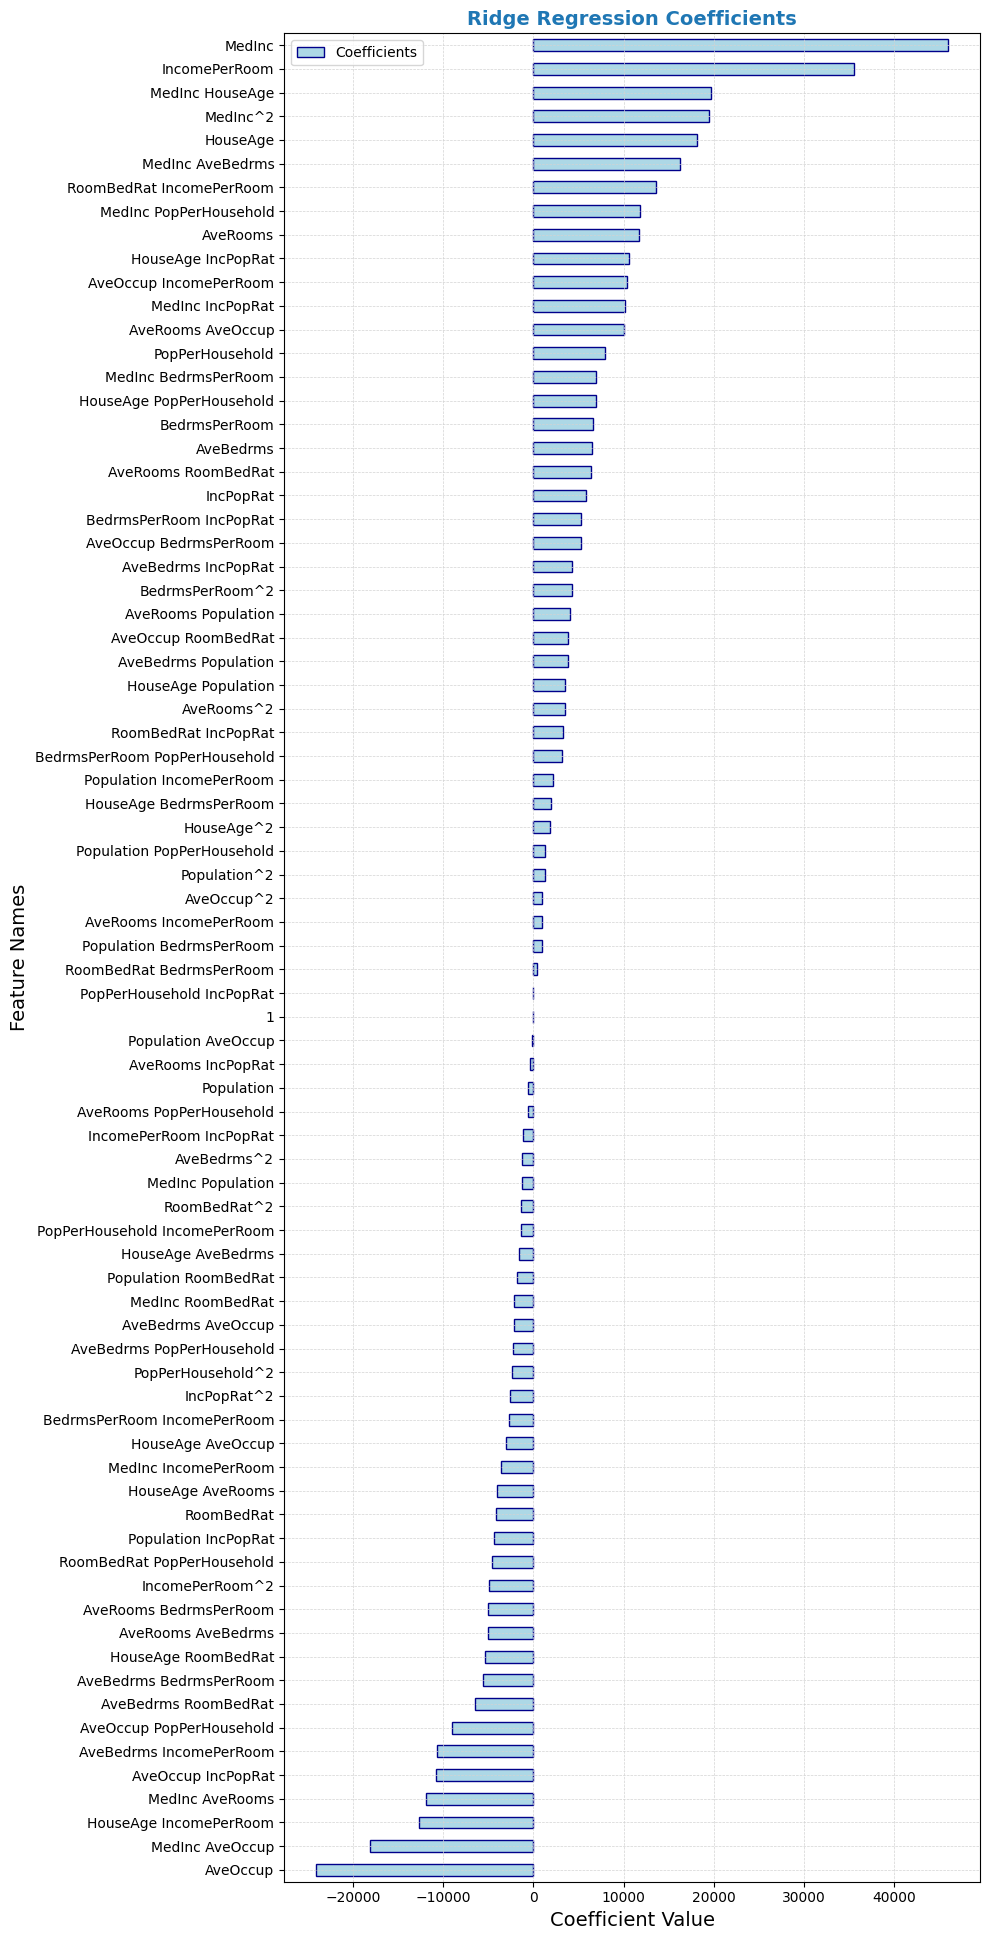

In [133]:
fig, ax = plt.subplots(figsize=(10, len(coef_df) * 0.25))  # Dynamic size based on number of features

# Plotting the coefficients
# Since you're looking to plot individual coefficients in a sorted order, a boxplot may not be the best choice.
# Instead, consider using a bar plot to show each coefficient's value.
coef_df.plot(kind='barh', x='Feature Names', y='Coefficients', ax=ax, color='lightblue', edgecolor='darkblue')

ax.set_title("Ridge Regression Coefficients", **title_specs)
ax.grid(**grid_specs)
ax.set_xlabel("Coefficient Value", fontsize=14)
ax.set_ylabel("Feature Names", fontsize=14)
ax.invert_yaxis()  # To have the highest values at the top

plt.tight_layout()

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Refitting the best model on the entire Train data set
</p>

In [136]:
predictions = grid_search_ridge.best_estimator_.predict(test_scaled_df)

rmse = np.sqrt(mean_squared_error(y_test, predictions)).round(4)

r_2_score = r2_score(y_test, predictions).round(4)

PrintColor(f'\nRoot mean squared error on the Test set: {rmse}\n')

PrintColor(f'\nR 2 score on Test set: {r_2_score}\n')


Mean squared error on the Test set: 69124.4946


R 2 score on Test set: 0.6445



<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
 Plotting actual vs predicted values
</p>

In [179]:
results = pd.DataFrame(data=
                       {'actual': y_test,
                        'predicted': predictions.ravel()}
                      )
results['residuals'] = results['actual'] - results['predicted']
results.head()

,actual,predicted,residuals
15051,"150,200.00000","121,679.19220","28,520.80780"
20682,"92,500.00000","121,483.97740","-28,983.97740"
55675,"242,400.00000","188,819.26183","53,580.73817"
6915,"232,400.00000","284,006.43902","-51,606.43902"
44243,"201,000.00000","265,247.26346","-64,247.26346"


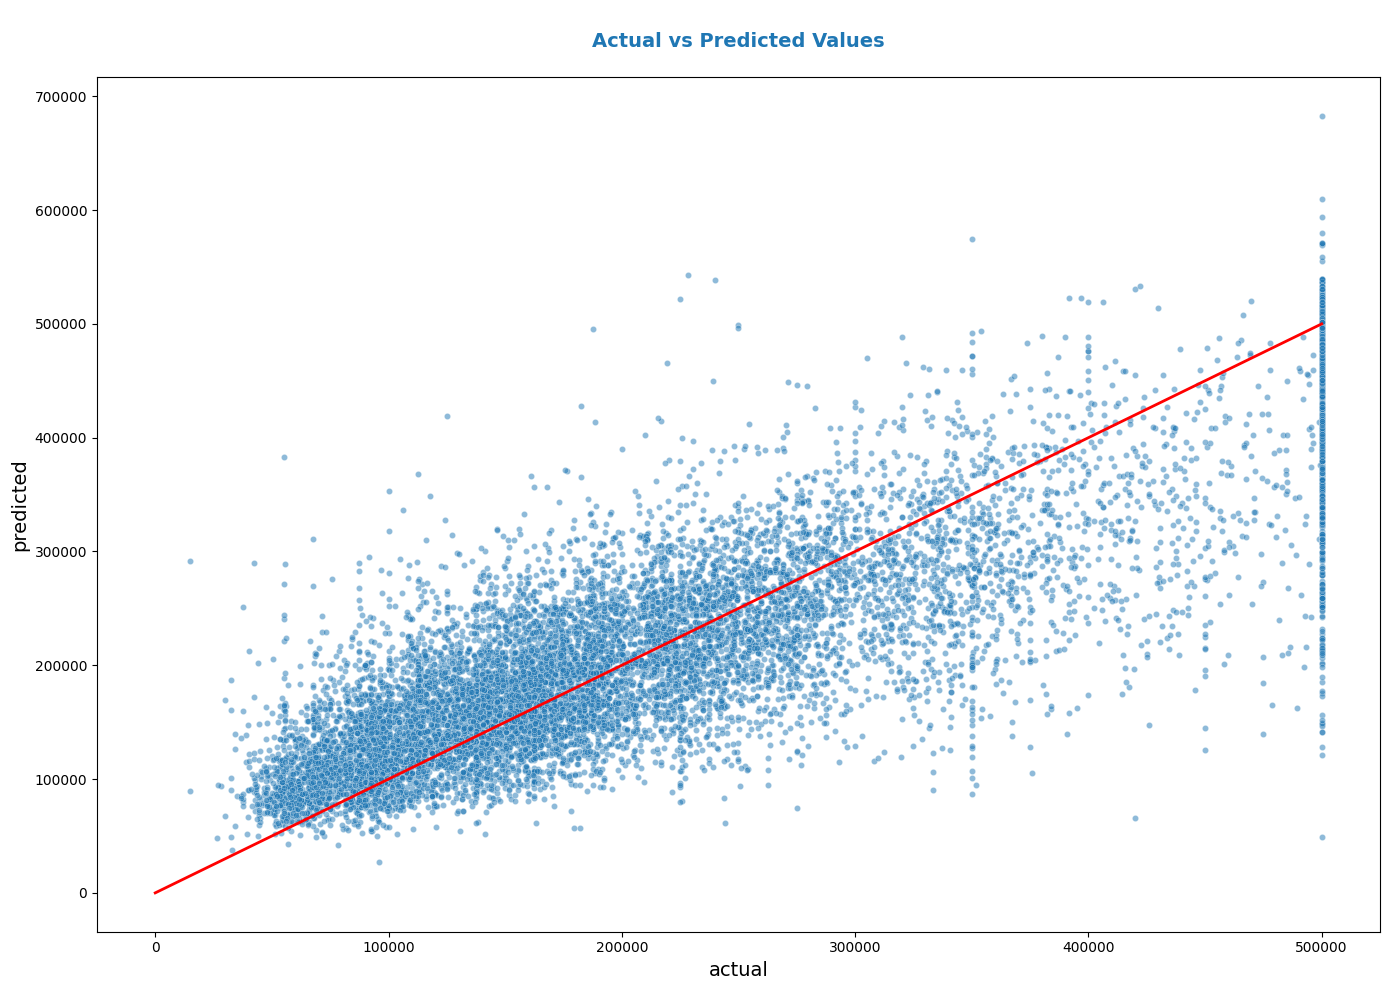

In [166]:
fig, ax = plt.subplots(figsize=(14,10))

sns.scatterplot(x = 'actual',
                y = 'predicted', 
                data = results,
                s = 20, alpha = 0.5,
                ax = ax)
ax.set_xlabel('actual', fontsize=14)
ax.set_ylabel('predicted', fontsize=14)
plt.plot([0, 500000], [0,500000], c='red', linewidth=2)
plt.title('\nActual vs Predicted Values\n', **title_specs)
plt.tight_layout();

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Visualizing the errors distribution 
</p>

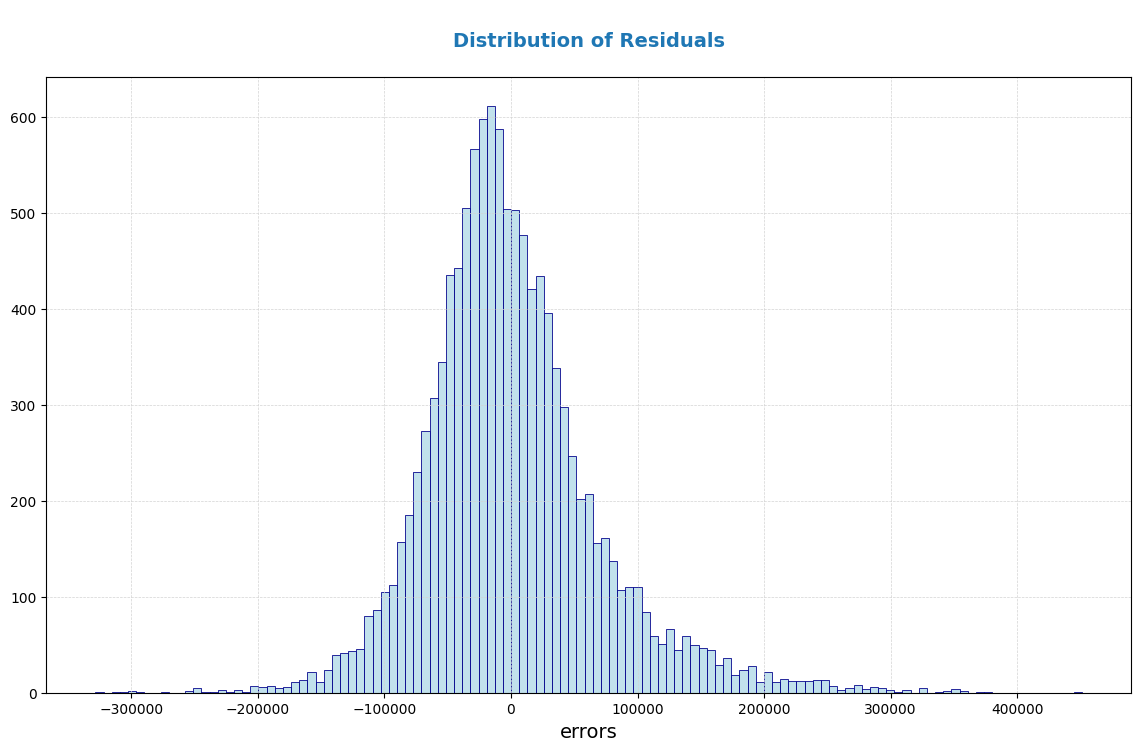

In [169]:
fig, ax = plt.subplots(figsize=(14,8))

sns.histplot(results['residuals'], color='lightblue', edgecolor='darkblue', ax=ax)
plt.title('\nDistribution of Residuals\n', **title_specs)
plt.grid(**grid_specs)
ax.set_xlabel('errors', fontsize=14)
ax.set_ylabel('');

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Generating QQ plot
</p>

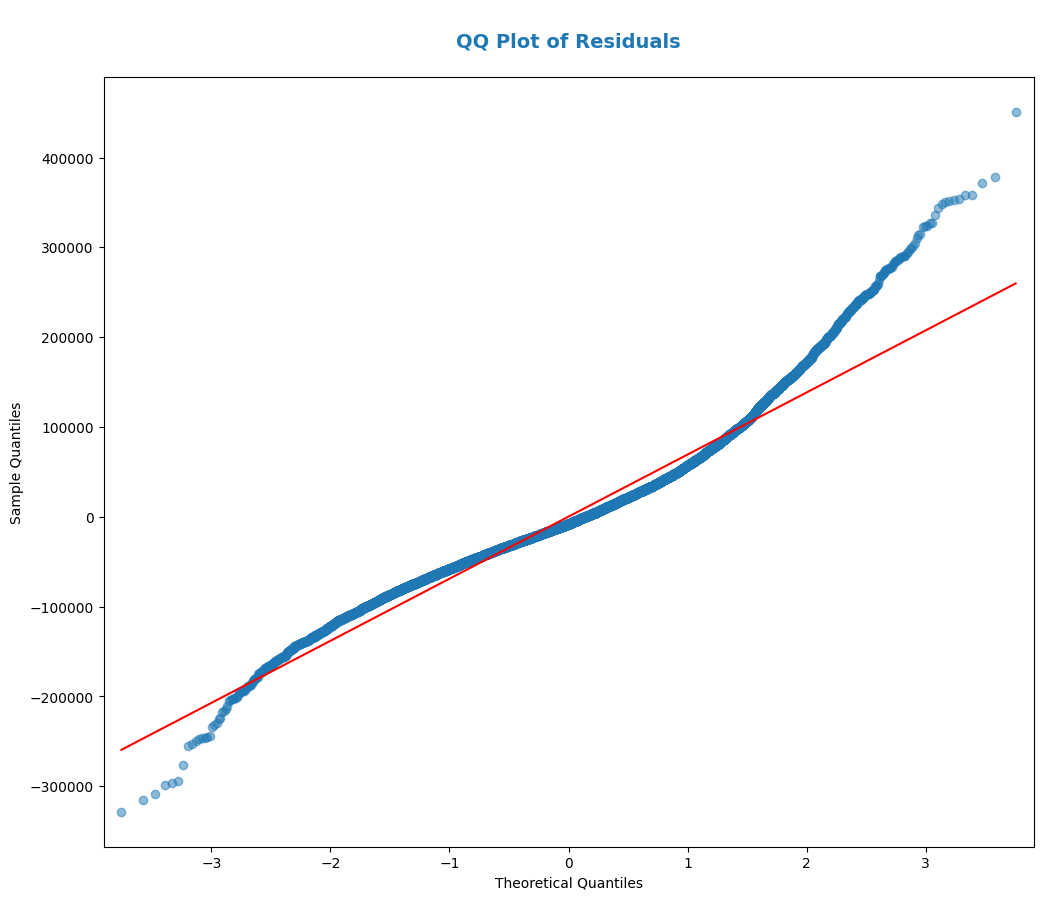

In [178]:
import statsmodels.api as sm

# Generate QQ plot
fig, ax = plt.subplots(figsize=(12, 10))

fig = sm.qqplot(results['residuals'], line='s', ax=ax, alpha=0.5)  # 's' for standardized line
plt.title('\nQQ Plot of Residuals\n', **title_specs);

<div style="color: #333333; 
           display: block; 
           border-radius: 12px;
           background-color: #FAFBFD; 
           font-size: 14px; 
           font-family: 'Roboto', sans-serif; 
           letter-spacing: 0.5px;
           padding: 20px; 
           border: 1px solid #CCCCCC; 
           ">
    
## Introduction
This project embarked on developing a predictive model for house price values, leveraging a dataset through meticulous analysis, feature engineering, and implementing Ridge regression. The primary goal was to unearth significant predictors that accurately estimate house price values.

## Key Findings

### Positive Contributions to House Price Values
The analysis illuminated key features with substantial positive impacts on house price values:
- **Median Income (MedInc):** Exhibits a prominent positive coefficient, signifying an increase in house price values with rising median income.
- **Income per Room (IncomePerRoom):** Indicates houses with a higher income per room ratio tend to command higher price values.
- **Median Income & House Age Interaction:** Showcases the combined influence of median income and house age on elevating house price values.
- **Square of Median Income:** Unveils a nonlinear enhancement of house price values with median income increments.
- **House Age:** Suggests a premium on older houses, possibly attributed to their desirable locations or heritage value.

### Negative Impact on House Price Values
Our findings also highlight features adversely affecting house price values:
- **Average Occupancy & Income to Population Ratio Interaction:** This interaction correlates with a decrement in house price values.
- **Median Income & Average Rooms Interaction:** Illustrates a negative impact on house price values, despite higher median income and average room count.
- **House Age & Income per Room Interaction:** Older houses with high income per room ratios tend to depreciate in value.
- **Median Income & Average Occupancy Interaction:** Indicates a diminishing effect on house price values.
- **Average Occupancy:** Directly associates higher occupancy rates with lower house price values.

### Performance Evaluation on the Test Dataset
Upon finalizing the model with optimal parameters identified via a nested cross-validation and grid search approach, the following outcomes were observed on the test dataset
- **Mean Squared Error (MSE):** 69,124.4946
- **R2 Score:** 0.6445

These metrics underscore a robust model fit, indicating that about 64.45% of variance in house price values is captured by our model.

### Insights and Implications
The distribution of residuals indicates a well-fitted model, with deviations likely stemming from data imputation practices. The model's coefficients offer profound insights into feature impacts on house prices, with median income notably pivotal. It is critical to interpret these coefficients with an understanding of preprocessing steps like standardization, indicating impacts in terms of standard deviations rather than raw units.

### Visualization Insights
- **Actual vs. Predicted Values:** A positive correlation between actual and predicted values signifies the model's precision in capturing data trends. Ideally, data points should cluster near the diagonal, indicating accurate predictions.
- **Error Distribution Analysis:** An almost normal distribution of residuals in the histogram suggests evenly spread errors around zero, implying no systematic bias in predictions and reinforcing homoscedasticity.
- **QQ Plot Analysis:** Residuals aligning with the theoretical line in a QQ plot affirm that errors follow a normal distribution, validating linear regression assumptions of homoscedasticity and independent distribution, pivotal for the model's predictive reliability.

## Conclusion
In this project, we created a model to forecast house prices, pinpointing key factors that affect these values. Our method involved detailed analysis and the use of advanced modeling techniques, which helped us understand what drives housing prices. The model's accuracy was thoroughly tested, ensuring it provides reliable insights for decision-makers in the housing market.
</div>